# **Bowtie metrics**

## 0 - Previous requirements

### Setup venv and install requirements

In [1]:
# Olivia Finder requirements
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Setup library path

In [2]:
# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia_finder/')

### Setup configuration

In [3]:
# Add the environment variable OLIVIA_FINDER_CONFIG_FILE_PATH
import os
os.environ['OLIVIA_FINDER_CONFIG_FILE_PATH'] = "../../olivia_finder/config.ini"

## Bowtie Structure

This function takes a network as input and returns a node set decomposition based on the tie-loop structure of the input network. The function uses the algorithm described in the article "Bow-tie decomposition in directed graphs" by R. Yang, L. Zhuhadar and O. Nasraoui.

The function starts by finding the largest strongly connected component of the input network using the `max` function of the `networkx` library. Next, an arbitrary node of the largest strongly connected component is selected and the forward and backward reachable nodes from the largest strongly connected component are computed using the `dfs_tree` function of the `networkx` library.

Next, the input and output components of the tie-loop structure are computed using the forward and backward reachable nodes. Nodes that are forward reachable but not backward make up the output component, while nodes that are backward reachable but not forward make up the input component.

After calculating the input and output components, the "tendril", "tube" and "disconnected" components are calculated. Nodes that are reachable forward and backward form a "pipe", nodes that are reachable backward but not forward form an input "tendril", nodes that are reachable forward but not backward form a "tendril". " output, and nodes that are neither forward nor backward reachable are considered disconnected.

Finally, the function returns the node sets for each component of the tie-loop structure: the largest strongly connected component, the input and output components, the "tendril", "tube", and "disconnected" components.

In short, this function is used to decompose a network into its bow-tie structure components using the algorithm described in the article "Bow-tie decomposition in directed graphs". The function returns the node sets for each component of the tie-loop structure, which can be useful for analyzing the network structure and understanding its behavior.

In [4]:
import networkx as nx

def bowtie_structure(network):
    """ 
    Return node set decomposition according to the bowtie structure of the input network.
    Algorithm from 
    R. Yang, L. Zhuhadar and O. Nasraoui, "Bow-tie decomposition in directed graphs",2011
    """
    
    largest_scc = max(nx.strongly_connected_components(network), key=len)
    
    # Arbitrary node from the largest SCC
    node = next(iter(largest_scc))
    
    # Reachable nodes (forward) from the largest SCC
    dfs = set(nx.dfs_tree(network,node).nodes())
    
    # Reachable nodes (backwards) from the largest SCC
    reversed_network = nx.reverse(network, copy=True)
    dfs_t = set(nx.dfs_tree(reversed_network,node).nodes())
    
    out_component = dfs - largest_scc
    in_component = dfs_t - largest_scc
    
    # Tendrils, tubes and disconnected components
    rest = set(network.nodes()) -  largest_scc - out_component - in_component

    tubes, in_tendrils, out_tendrils, disconnected  = set(), set(), set(), set()

    for v in rest:
        # in_component nodes backwards reachable from v
        irv = in_component & set(nx.dfs_tree(reversed_network, v).nodes())
        # out_component nodes reachable from v
        vro = out_component & set(nx.dfs_tree(network, v).nodes())
        
        if irv and vro:
            tubes.add(v)
        elif irv and not vro:
            in_tendrils.add(v)
        elif not irv and vro:
            out_tendrils.add(v)
        else:
            disconnected.add(v)
            
    return  largest_scc, in_component, out_component, tubes, in_tendrils, out_tendrils, disconnected

## Analysis

In [12]:
from olivia_finder.package_manager import PackageManager

### Bioconductor

In [13]:
# Build bioconductor graph
bioconductor = PackageManager.load_from_persistence('../olivia_finder/resources/bioconductor_scraper.olvpm')
bioconductor_G = bioconductor.get_network()

In [17]:
bio_largest_scc, bio_in_component, bio_out_component, bio_tubes, bio_in_tendrils, bio_out_tendrils, bio_disconnected = bowtie_structure(bioconductor_G)

len(bio_largest_scc)+\
len(bio_in_component)+\
len(bio_out_component)+\
len(bio_tubes)+\
len(bio_in_tendrils)+\
len(bio_out_tendrils)+\
len(bio_disconnected) == len(bioconductor_G.nodes())


True

In [22]:
print(f"Bioconductor bowtie structure:\n\
      Largest SCC: {len(bio_largest_scc)}\n\
      In component: {len(bio_in_component)}\n\
      Out component: {len(bio_out_component)}\n\
      Tubes: {len(bio_tubes)}\n\
      In tendrils: {len(bio_in_tendrils)}\n\
      Out tendrils: {len(bio_out_tendrils)}\n\
      Disconnected: {len(bio_disconnected)}")


Bioconductor bowtie structure:
      Largest SCC: 1
      In component: 124
      Out component: 0
      Tubes: 0
      In tendrils: 2161
      Out tendrils: 0
      Disconnected: 1223


### CRAN

In [18]:
cran = PackageManager.load_from_persistence('../olivia_finder/results/package_managers/cran_scraper.olvpm')
cran_G = cran.get_network()

In [19]:
cran_largest_scc, cran_in_component, cran_out_component, cran_tubes, cran_in_tendrils, cran_out_tendrils, cran_disconnected = bowtie_structure(cran_G)

len(cran_largest_scc)+\
len(cran_in_component)+\
len(cran_out_component)+\
len(cran_tubes)+\
len(cran_in_tendrils)+\
len(cran_out_tendrils)+\
len(cran_disconnected) == len(cran_G)

True

In [21]:
print(f"CRAN bowtie structure:\n\
      Largest SCC: {len(cran_largest_scc)}\n\
      In component: {len(cran_in_component)}\n\
      Out component: {len(cran_out_component)}\n\
      Tubes: {len(cran_tubes)}\n\
      In tendrils: {len(cran_in_tendrils)}\n\
      Out tendrils: {len(cran_out_tendrils)}\n\
      Disconnected: {len(cran_disconnected)}")

CRAN bowtie structure:
      Largest SCC: 1
      In component: 6
      Out component: 0
      Tubes: 0
      In tendrils: 18171
      Out tendrils: 0
      Disconnected: 689


### Pypi

In [ ]:
pypi = PackageManager.load_from_persistence('../olivia_finder/results/package_managers/pypi_scraper.olvpm')
pypi_G = pypi.get_network()

In [ ]:
pypi_largest_scc, pypi_in_component, pypi_out_component, pypi_tubes, pypi_in_tendrils, pypi_out_tendrils, pypi_disconnected = bowtie_structure(pypi_G)

len(pypi_largest_scc)+\
len(pypi_in_component)+\
len(pypi_out_component)+\
len(pypi_tubes)+\
len(pypi_in_tendrils)+\
len(pypi_out_tendrils)+\
len(pypi_disconnected) == len(pypi_G)

In [ ]:
print(f"PyPI bowtie structure:\n\
      Largest SCC: {len(pypi_largest_scc)}\n\
      In component: {len(pypi_in_component)}\n\
      Out component: {len(pypi_out_component)}\n\
      Tubes: {len(pypi_tubes)}\n\
      In tendrils: {len(pypi_in_tendrils)}\n\
      Out tendrils: {len(pypi_out_tendrils)}\n\
      Disconnected: {len(pypi_disconnected)}")

### NPM

In [10]:
npm = PackageManager.load_from_persistence('../olivia_finder/results/package_managers/npm_scraper.olvpm')
npm_G = npm.get_network()

In [ ]:
npm_largest_scc, npm_in_component, npm_out_component, npm_tubes, npm_in_tendrils, npm_out_tendrils, npm_disconnected = bowtie_structure(npm_G)

len(npm_largest_scc)+\
len(npm_in_component)+\
len(npm_out_component)+\
len(npm_tubes)+\
len(npm_in_tendrils)+\
len(npm_out_tendrils)+\
len(npm_disconnected) == len(npm_G)

In [ ]:
print(f"NPM bowtie structure:\n\
      Largest SCC: {len(npm_largest_scc)}\n\
      In component: {len(npm_in_component)}\n\
      Out component: {len(npm_out_component)}\n\
      Tubes: {len(npm_tubes)}\n\
      In tendrils: {len(npm_in_tendrils)}\n\
      Out tendrils: {len(npm_out_tendrils)}\n\
      Disconnected: {len(npm_disconnected)}")

## Results

In [23]:
# Build a table with the bowtie structure of each package manager
import pandas as pd


bowtie_table = pd.DataFrame(columns=['Largest SCC', 'In component', 'Out component', 'Tubes', 'In tendrils', 'Out tendrils', 'Disconnected'])
bowtie_table.loc['Bioconductor'] = [len(bio_largest_scc), len(bio_in_component), len(bio_out_component), len(bio_tubes), len(bio_in_tendrils), len(bio_out_tendrils), len(bio_disconnected)]
bowtie_table.loc['CRAN'] = [len(cran_largest_scc), len(cran_in_component), len(cran_out_component), len(cran_tubes), len(cran_in_tendrils), len(cran_out_tendrils), len(cran_disconnected)]
bowtie_table.loc['PyPI'] = [len(pypi_largest_scc), len(pypi_in_component), len(pypi_out_component), len(pypi_tubes), len(pypi_in_tendrils), len(pypi_out_tendrils), len(pypi_disconnected)]
bowtie_table.loc['NPM'] = [len(npm_largest_scc), len(npm_in_component), len(npm_out_component), len(npm_tubes), len(npm_in_tendrils), len(npm_out_tendrils), len(npm_disconnected)]

NameError: name 'pypi_largest_scc' is not defined

In [24]:
bowtie_table

,Largest SCC,In component,Out component,Tubes,In tendrils,Out tendrils,Disconnected
Bioconductor,1,124,0,0,2161,0,1223
CRAN,1,6,0,0,18171,0,689


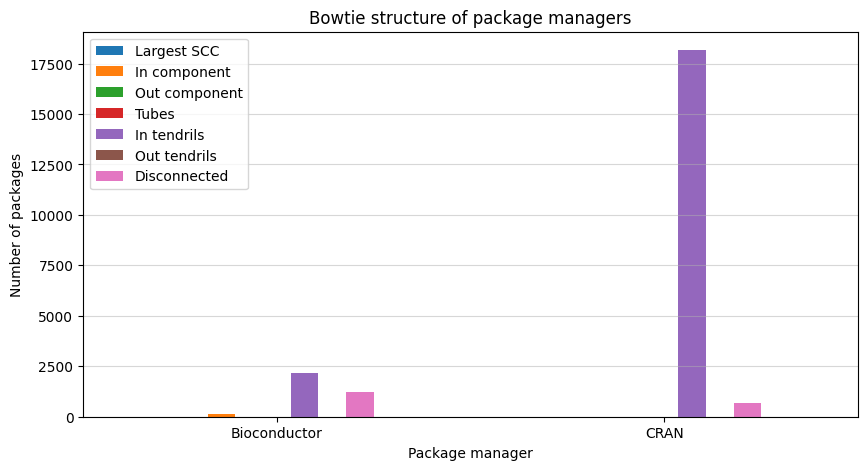

In [31]:
from matplotlib import pyplot as plt

bowtie_table.plot.bar(figsize=(10,5), rot=0, title='Bowtie structure of package managers', ylabel='Number of packages', xlabel='Package manager')

# Add a grid
plt.grid(axis='y', alpha=0.5)
plt.show()